# Electricity price forecasting

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
import seaborn as sns
import pickle
from tqdm import tqdm
import math
import os

In [2]:
file= 'E:\CIT\MSc_AI\Research project_NIMBUS\Rework\corrected_data.xlsx'
data= pd.read_excel(file, sheet_name='data_2019')
print(data.shape)
data.head(5)

(8304, 16)


,applicable_date,elec_prices,rain_d,temp_d,wdsp_d,wddir_d,rain_c,temp_c,wdsp_c,wddir_c,rain_g,temp_g,wdsp_g,wddir_g,daily_oil_price,daily_natural_gas
0,2019-01-01 00:00:00,70.28,0.0,8.8,4.626,250,0.0,8.5,2.056,240,0.0,9.9,2.056,260,59.41,2.61649
1,2019-01-01 01:00:00,65.18,0.0,8.3,4.626,250,0.0,8.5,1.542,270,0.0,9.3,2.056,240,59.41,2.61649
2,2019-01-01 02:00:00,60.91,0.0,8.4,4.112,240,0.0,8.4,1.542,280,0.0,9.2,2.570,240,59.41,2.61649
3,2019-01-01 03:00:00,65.16,0.0,8.6,4.112,250,0.0,8.5,2.570,260,0.0,9.1,2.570,250,59.41,2.61649
4,2019-01-01 04:00:00,65.16,0.0,8.4,5.140,250,0.0,8.5,2.570,270,0.0,8.8,2.056,250,59.41,2.61649


In [3]:
data.isnull().values.any()

False

## Exploratory data analysis

In [4]:
def plot_pdf(data,feature):
    import warnings 
    warnings.filterwarnings("ignore")

    sns.FacetGrid(data,size=5) \
       .map(sns.distplot,feature) \
       .add_legend()
    plt.xlabel(feature +" in €")
    plt.ylabel('PDF')
    plt.title("Probability distribution of "+feature)
    plt.grid()
    plt.show()

In [5]:
def scatter_plot(x,y,col_name):
    plt.figure(figsize=(15,6))
    plt.plot(x, y, 'o', color='blue')
    plt.title("Scatter plot of "+col_name)
    plt.xlabel("instances")
    plt.ylabel(col_name)

### Univariate Analysis of the target variable (price) 

In [6]:
# Basic stats:
data.elec_prices.describe()

count    8304.000000
mean       50.572471
std        23.430899
min       -11.860000
25%        38.417500
50%        47.394000
75%        59.000000
max       365.040000
Name: elec_prices, dtype: float64

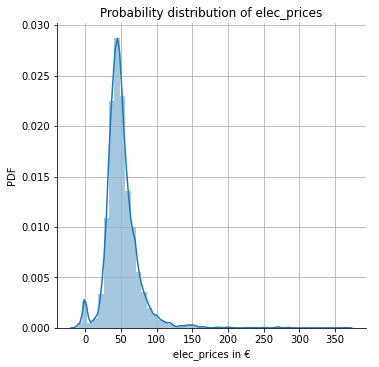

In [7]:
plot_pdf(data,'elec_prices')

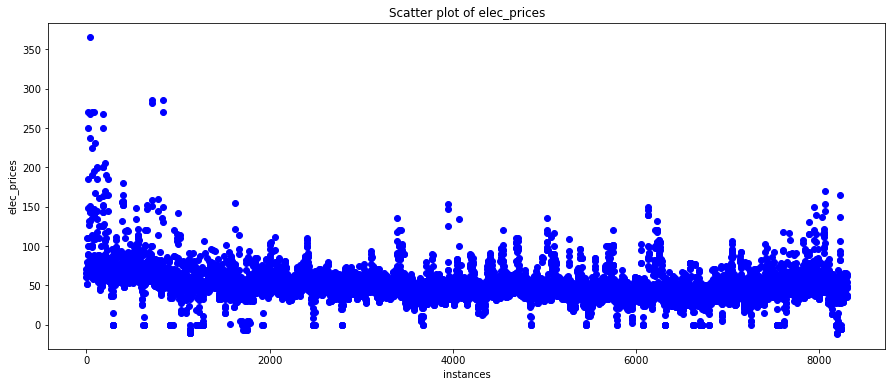

In [8]:
scatter_plot(range(data.shape[0]),data["elec_prices"].values,'elec_prices')

Text(0, 0.5, 'elec_prices')

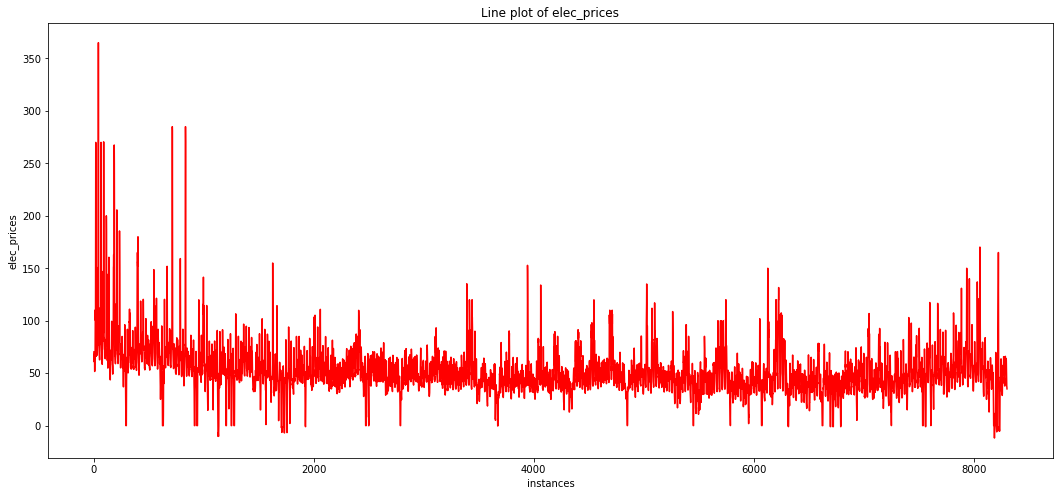

In [9]:
plt.figure(figsize=(18,8))
plt.plot(range(data.shape[0]), data["elec_prices"].values,color='red')
plt.title("Line plot of elec_prices")
plt.xlabel("instances")
plt.ylabel("elec_prices")

### Feature correlation

In [10]:
from scipy.stats import pearsonr
def calc_PCC(x,y,feature):
    '''Function that takes 2 continuous variables and returns the PCC value'''
    corr, _ = pearsonr(x, y)
    print('Pearsons correlation for '+feature+ ' with electricity price: %.3f' % corr)

In [12]:
cols = data.columns.to_list()
x= data.elec_prices.values
for col in range(2,len(cols)):
    y = data[cols[col]].values
    calc_PCC(x,y,cols[col])

Pearsons correlation for rain_d with electricity price: -0.035
Pearsons correlation for temp_d with electricity price: -0.143
Pearsons correlation for wdsp_d with electricity price: -0.237
Pearsons correlation for wddir_d with electricity price: -0.004
Pearsons correlation for rain_c with electricity price: -0.054
Pearsons correlation for temp_c with electricity price: -0.120
Pearsons correlation for wdsp_c with electricity price: -0.286
Pearsons correlation for wddir_c with electricity price: -0.038
Pearsons correlation for rain_g with electricity price: -0.090
Pearsons correlation for temp_g with electricity price: -0.107
Pearsons correlation for wdsp_g with electricity price: -0.315
Pearsons correlation for wddir_g with electricity price: -0.039
Pearsons correlation for daily_oil_price with electricity price: -0.088
Pearsons correlation for daily_natural_gas with electricity price: 0.259


### Feature engineering

In [13]:
data.head()

,applicable_date,elec_prices,rain_d,temp_d,wdsp_d,wddir_d,rain_c,temp_c,wdsp_c,wddir_c,rain_g,temp_g,wdsp_g,wddir_g,daily_oil_price,daily_natural_gas
0,2019-01-01 00:00:00,70.28,0.0,8.8,4.626,250,0.0,8.5,2.056,240,0.0,9.9,2.056,260,59.41,2.61649
1,2019-01-01 01:00:00,65.18,0.0,8.3,4.626,250,0.0,8.5,1.542,270,0.0,9.3,2.056,240,59.41,2.61649
2,2019-01-01 02:00:00,60.91,0.0,8.4,4.112,240,0.0,8.4,1.542,280,0.0,9.2,2.570,240,59.41,2.61649
3,2019-01-01 03:00:00,65.16,0.0,8.6,4.112,250,0.0,8.5,2.570,260,0.0,9.1,2.570,250,59.41,2.61649
4,2019-01-01 04:00:00,65.16,0.0,8.4,5.140,250,0.0,8.5,2.570,270,0.0,8.8,2.056,250,59.41,2.61649


In [14]:
data.tail()

,applicable_date,elec_prices,rain_d,temp_d,wdsp_d,wddir_d,rain_c,temp_c,wdsp_c,wddir_c,rain_g,temp_g,wdsp_g,wddir_g,daily_oil_price,daily_natural_gas
8299,2019-12-12 19:00:00,49.733,0.8,6.9,3.084,230,0.4,6.9,10.794,280,1.1,5.7,6.682,300,66.67,2.03604
8300,2019-12-12 20:00:00,47.186,2.4,5.8,4.112,240,0.1,6.3,10.280,280,0.8,5.3,5.140,280,66.67,2.03604
8301,2019-12-12 21:00:00,37.410,2.0,5.1,7.710,270,0.0,5.9,9.252,280,0.2,5.1,5.654,280,66.67,2.03604
8302,2019-12-12 22:00:00,37.040,0.2,4.2,9.766,270,0.2,4.9,9.252,280,0.5,5.3,5.654,290,66.67,2.03604
8303,2019-12-12 23:00:00,35.000,0.0,4.4,8.224,270,0.0,5.4,9.766,280,0.4,5.2,6.682,280,66.67,2.03604


#### Rain

In [15]:
x= data.elec_prices.values
rain_sum= (data['rain_d']+data['rain_c']+data['rain_g']).values
rain_sq= (data['rain_d']*data['rain_d']+data['rain_c']*data['rain_c']+data['rain_g']*data['rain_g']).values
rain_sum_log= np.log(rain_sum+ 0.00001)
rain_sum_sqrt= np.sqrt(rain_sum)

calc_PCC(x,rain_sum,'rain_sum')
calc_PCC(x,rain_sq,'rain_sq')
calc_PCC(x,rain_sum_log,'rain_sum_log')
calc_PCC(x,rain_sum_sqrt,'rain_sum_sqrt')

Pearsons correlation for rain_sum with electricity price: -0.094
Pearsons correlation for rain_sq with electricity price: -0.040
Pearsons correlation for rain_sum_log with electricity price: -0.147
Pearsons correlation for rain_sum_sqrt with electricity price: -0.133


In [16]:
rain_avg = rain_sum/3
rain_avg_sq = rain_avg*rain_avg
rain_avg_log = np.log(rain_avg+ 0.00001)
rain_avg_sqrt= np.sqrt(rain_avg)
calc_PCC(x,rain_avg,'rain_avg')
calc_PCC(x,rain_avg_sq,'rain_avg_sq')
calc_PCC(x,rain_avg_log,'rain_avg_log')
calc_PCC(x,rain_avg_sqrt,'rain_avg_sqrt')

Pearsons correlation for rain_avg with electricity price: -0.094
Pearsons correlation for rain_avg_sq with electricity price: -0.045
Pearsons correlation for rain_avg_log with electricity price: -0.147
Pearsons correlation for rain_avg_sqrt with electricity price: -0.133


In [17]:
rain_avg

array([0.        , 0.        , 0.        , ..., 0.73333333, 0.3       ,
       0.13333333])

In [18]:
rain_sum

array([0. , 0. , 0. , ..., 2.2, 0.9, 0.4])

#### Wind direction

In [20]:
x= data.elec_prices.values
wind_sum= (data['wddir_d']+data['wddir_c']+data['wddir_g']).values
wind_sqr= (data['wddir_d']*data['wddir_d']+data['wddir_c']*data['wddir_c']+data['wddir_g']*data['wddir_g']).values
wind_sum_log= np.log(wind_sum)
wind_sum_sqrt= np.sqrt(wind_sum)

calc_PCC(x,wind_sum,'wind_sum')
calc_PCC(x,wind_sqr,'wind_sqr')
calc_PCC(x,wind_sum_log,'wind_sum_log')
calc_PCC(x,wind_sum_sqrt,'wind_sum_sqrt')

Pearsons correlation for wind_sum with electricity price: -0.033
Pearsons correlation for wind_sqr with electricity price: -0.018
Pearsons correlation for wind_sum_log with electricity price: -0.028
Pearsons correlation for wind_sum_sqrt with electricity price: -0.031


In [21]:
wind_avg = wind_sum/3
wind_avg_sq = wind_avg*wind_avg
wind_avg_log = np.log(wind_avg+ 0.00001)
wind_avg_sqrt= np.sqrt(wind_avg)
calc_PCC(x,wind_avg,'wind_avg')
calc_PCC(x,wind_avg_sq,'wind_avg_sq')
calc_PCC(x,wind_avg_log,'wind_avg_log')
calc_PCC(x,wind_avg_sqrt,'wind_avg_sqrt')

Pearsons correlation for wind_avg with electricity price: -0.033
Pearsons correlation for wind_avg_sq with electricity price: -0.035
Pearsons correlation for wind_avg_log with electricity price: -0.028
Pearsons correlation for wind_avg_sqrt with electricity price: -0.031


#### Oil prices

In [22]:
x= data.elec_prices.values
oil= data['daily_oil_price'].values
oil_sqr= oil*oil
oil_sqrt= np.sqrt(oil)
oil_log= np.log(oil)

calc_PCC(x,oil_sqr,'oil_sqr')
calc_PCC(x,oil_sqrt,'oil_sqrt')
calc_PCC(x,oil_log,'oil_log')

Pearsons correlation for oil_sqr with electricity price: -0.083
Pearsons correlation for oil_sqrt with electricity price: -0.090
Pearsons correlation for oil_log with electricity price: -0.092


#### Natural gas prices

In [23]:
x= data.elec_prices.values
ng = data.daily_natural_gas.values
ng_sqr = ng*ng
ng_sqrt = np.sqrt(ng)
ng_log= np.log(ng)

calc_PCC(x,ng_sqr,'ng_sqr')
calc_PCC(x,ng_sqrt,'ng_sqrt')
calc_PCC(x,ng_log,'ng_log')

Pearsons correlation for ng_sqr with electricity price: 0.257
Pearsons correlation for ng_sqrt with electricity price: 0.257
Pearsons correlation for ng_log with electricity price: 0.255


#### temperature

In [25]:
temp_sum= (data['temp_d']+data['temp_c']+data['temp_g'])
temp_sqr= (data['temp_d']*data['temp_d']+data['temp_c']*data['temp_c']+data['temp_g']*data['temp_g'])
temp_sum_log= np.log(temp_sum+ 00000.1)
temp_sum_log = temp_sum_log.ffill(axis = 0)
temp_sum_sqrt= np.sqrt(temp_sum)
temp_sum_sqrt= temp_sum_sqrt.ffill(axis = 0)

calc_PCC(x,temp_sum.values,'temp_sum')
calc_PCC(x,temp_sqr.values,'temp_sqr')
calc_PCC(x,temp_sum_log.values,'temp_sum_log')
calc_PCC(x,temp_sum_sqrt.values,'temp_sum_sqrt')

Pearsons correlation for temp_sum with electricity price: -0.127
Pearsons correlation for temp_sqr with electricity price: -0.098
Pearsons correlation for temp_sum_log with electricity price: -0.137
Pearsons correlation for temp_sum_sqrt with electricity price: -0.139


In [27]:
temp_avg = temp_sum/3
temp_avg_sq = temp_avg*temp_avg
temp_avg_log = np.log(temp_avg+ 0.00001)
temp_avg_sqrt= np.sqrt(temp_avg)
calc_PCC(x,temp_avg,'temp_avg')
calc_PCC(x,temp_avg_sq,'temp_avg_sq')
calc_PCC(x,temp_avg_log,'temp_avg_log')
calc_PCC(x,temp_avg_sqrt,'temp_avg_sqrt')

Pearsons correlation for temp_avg with electricity price: -0.127
Pearsons correlation for temp_avg_sq with electricity price: -0.098


ValueError: array must not contain infs or NaNs

In [29]:
np.sqrt(0)

0.0

#### wind speed

In [30]:
wdsp_sum= (data['wdsp_d']+data['wdsp_c']+data['wdsp_g']).values
wdsp_sqr= (data['wdsp_d']*data['wdsp_d']+data['wdsp_c']*data['wdsp_c']+data['wdsp_g']*data['wdsp_g']).values
wdsp_sum_log= np.log(wdsp_sum)
wdsp_sum_sqrt= np.sqrt(wdsp_sum)

calc_PCC(x,wdsp_sum,'wdsp_sum')
calc_PCC(x,wdsp_sqr,'wdsp_sqr')
calc_PCC(x,wdsp_sum_log,'wdsp_sum_log')
calc_PCC(x,wdsp_sum_sqrt,'wdsp_sum_sqrt')

Pearsons correlation for wdsp_sum with electricity price: -0.318
Pearsons correlation for wdsp_sqr with electricity price: -0.304
Pearsons correlation for wdsp_sum_log with electricity price: -0.299
Pearsons correlation for wdsp_sum_sqrt with electricity price: -0.313


In [31]:
wdsp_avg = wdsp_sum/3
wdsp_avg_sq = wdsp_avg*wdsp_avg
wdsp_avg_log = np.log(wdsp_avg+ 0.00001)
wdsp_avg_sqrt= np.sqrt(wdsp_avg)
calc_PCC(x,wdsp_avg,'wdsp_avg')
calc_PCC(x,wdsp_avg_sq,'wdsp_avg_sq')
calc_PCC(x,wdsp_avg_log,'wdsp_avg_log')
calc_PCC(x,wdsp_avg_sqrt,'wdsp_avg_sqrt')

Pearsons correlation for wdsp_avg with electricity price: -0.318
Pearsons correlation for wdsp_avg_sq with electricity price: -0.308
Pearsons correlation for wdsp_avg_log with electricity price: -0.299
Pearsons correlation for wdsp_avg_sqrt with electricity price: -0.313


#### Expanding Window Feature

In [15]:
x= data.elec_prices.values
y = data['elec_prices'].expanding().mean()
calc_PCC(x,y.values,'expanding_window_price')

Pearsons correlation for expanding_window_price with electricity price: 0.396


In [33]:
# lag of expanding window feature
y = data['elec_prices'].expanding().mean()
y_lag1 = y.shift(1)
y_lag1 = y_lag1.bfill(axis ='rows')

calc_PCC(x,y_lag1.values,'expanding_window_price_lag1')

Pearsons correlation for expanding_window_price_lag1 with electricity price: 0.389


### Time based features

In [34]:
data.head()

,applicable_date,elec_prices,rain_d,temp_d,wdsp_d,wddir_d,rain_c,temp_c,wdsp_c,wddir_c,rain_g,temp_g,wdsp_g,wddir_g,daily_oil_price,daily_natural_gas
0,2019-01-01 00:00:00,70.28,0.0,8.8,4.626,250,0.0,8.5,2.056,240,0.0,9.9,2.056,260,59.41,2.61649
1,2019-01-01 01:00:00,65.18,0.0,8.3,4.626,250,0.0,8.5,1.542,270,0.0,9.3,2.056,240,59.41,2.61649
2,2019-01-01 02:00:00,60.91,0.0,8.4,4.112,240,0.0,8.4,1.542,280,0.0,9.2,2.570,240,59.41,2.61649
3,2019-01-01 03:00:00,65.16,0.0,8.6,4.112,250,0.0,8.5,2.570,260,0.0,9.1,2.570,250,59.41,2.61649
4,2019-01-01 04:00:00,65.16,0.0,8.4,5.140,250,0.0,8.5,2.570,270,0.0,8.8,2.056,250,59.41,2.61649


In [35]:
data_= data.copy()
data_.shape

(8304, 16)

In [36]:
data_.iloc[-1]

applicable_date      2019-12-12 23:00:00
elec_prices                           35
rain_d                                 0
temp_d                               4.4
wdsp_d                             8.224
wddir_d                              270
rain_c                                 0
temp_c                               5.4
wdsp_c                             9.766
wddir_c                              280
rain_g                               0.4
temp_g                               5.2
wdsp_g                             6.682
wddir_g                              280
daily_oil_price                    66.67
daily_natural_gas                2.03604
Name: 8303, dtype: object

In [37]:
time_data= data_.copy()
time_data= time_data[['applicable_date','elec_prices']]
time_data.head()

,applicable_date,elec_prices
0,2019-01-01 00:00:00,70.28
1,2019-01-01 01:00:00,65.18
2,2019-01-01 02:00:00,60.91
3,2019-01-01 03:00:00,65.16
4,2019-01-01 04:00:00,65.16


In [38]:
#time_data['year']=time_data['applicable_date'].dt.year 
time_data['month']=time_data['applicable_date'].dt.month 
time_data['day']=time_data['applicable_date'].dt.day

time_data['dayofweek_num']=time_data['applicable_date'].dt.dayofweek
time_data['dayofyear_num']=time_data['applicable_date'].dt.dayofyear
time_data['weekofyear_num']=time_data['applicable_date'].dt.weekofyear
time_data['dayofweek_name']=time_data['applicable_date'].dt.day_name()

time_data['Hour'] = time_data['applicable_date'].dt.hour

time_data.head()

,applicable_date,elec_prices,month,day,dayofweek_num,dayofyear_num,weekofyear_num,dayofweek_name,Hour
0,2019-01-01 00:00:00,70.28,1,1,1,1,1,Tuesday,0
1,2019-01-01 01:00:00,65.18,1,1,1,1,1,Tuesday,1
2,2019-01-01 02:00:00,60.91,1,1,1,1,1,Tuesday,2
3,2019-01-01 03:00:00,65.16,1,1,1,1,1,Tuesday,3
4,2019-01-01 04:00:00,65.16,1,1,1,1,1,Tuesday,4


In [39]:
time_data.isnull().values.any()

False

time_data= time_data.drop(['year'], axis=1)
time_data.head()

In [40]:
time_data['dayofweek_num'].unique()

array([1, 2, 3, 4, 5, 6, 0], dtype=int64)

In [41]:
time_data['dayofyear_num'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [42]:
time_data['weekofyear_num'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
      dtype=int64)

In [43]:
time_data['dayofweek_name'].unique()

array(['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
       'Monday'], dtype=object)

In [44]:
time_data['Hour'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int64)

In [45]:
x= time_data['elec_prices'].values
y = time_data['month'].values
calc_PCC(x,y,'month')

Pearsons correlation for month with electricity price: -0.254


In [46]:
y = time_data['day'].values
calc_PCC(x,y,'day')

Pearsons correlation for day with electricity price: -0.036


In [47]:
y = time_data['dayofweek_num'].values
calc_PCC(x,y,'dayofweek_num')

Pearsons correlation for dayofweek_num with electricity price: -0.131


In [48]:
y = time_data['Hour'].values
calc_PCC(x,y,'Hour')

Pearsons correlation for Hour with electricity price: 0.254


In [49]:
y = time_data['dayofyear_num'].values
calc_PCC(x,y,'dayofyear_num')

Pearsons correlation for dayofyear_num with electricity price: -0.256


In [50]:
y = time_data['weekofyear_num'].values
calc_PCC(x,y,'weekofyear_num')

Pearsons correlation for weekofyear_num with electricity price: -0.253


### correlation between dayofweek_name & price

In [51]:
from sklearn import preprocessing
day_name= time_data['dayofweek_name'].values
le = preprocessing.LabelEncoder()
labels= le.fit_transform(day_name)

In [52]:
len(labels)

8304

In [53]:
le.classes_

array(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'], dtype=object)

In [54]:
y = labels
calc_PCC(x,y,'dayofweek_name')

Pearsons correlation for dayofweek_name with electricity price: 0.046
